In [ ]:
!pip install torch_geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 15.0 MB/s eta 0:00:00


In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import torch
from torch_geometric.data import Data

# Node features: positions (x, y)
node_features = torch.tensor([
    [0, 0],  # Node 0
    [1, 0],  # Node 1
    [0.5, 1]  # Node 2
], dtype=torch.float)

# Edge connections: 3 edges between the 3 nodes
edge_index = torch.tensor([
    [0, 1, 2],  # From node 0 to 1, 0 to 2, 1 to 2
    [1, 2, 0]   # Corresponding destination nodes
], dtype=torch.long)

# Edge attributes: lengths of the truss members (example values)
edge_attr = torch.tensor([
    [1.0],  # Length of edge 0-1
    [2.0],  # Length of edge 0-2
    [2.236]  # Length of edge 1-2 (hypotenuse)
], dtype=torch.float)

# Create PyG Data object
truss_graph = Data(x=node_features, edge_index=edge_index, edge_attr=edge_attr)


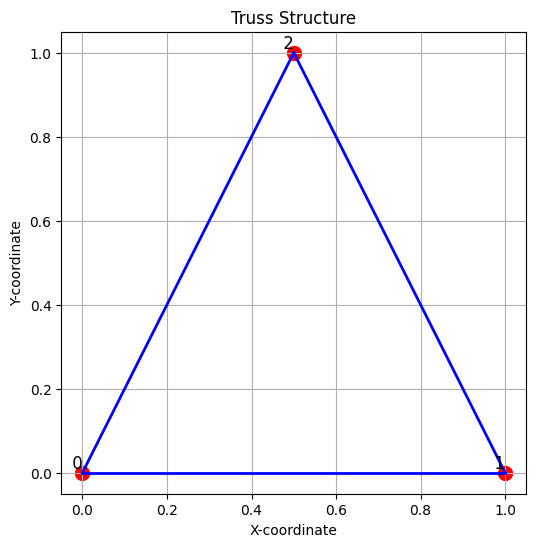

In [ ]:
# Function to plot the truss structure
def plot_truss(graph):
    # Extract the node positions and edge connections
    node_positions = graph.x.numpy()
    edges = graph.edge_index.numpy()

    plt.figure(figsize=(6, 6))

    # Plot edges
    for i in range(edges.shape[1]):
        start_node = edges[0, i]
        end_node = edges[1, i]
        start_pos = node_positions[start_node]
        end_pos = node_positions[end_node]
        plt.plot([start_pos[0], end_pos[0]], [start_pos[1], end_pos[1]], 'b-', lw=2)

    # Plot nodes
    plt.scatter(node_positions[:, 0], node_positions[:, 1], s=100, c='red')

    # Annotate nodes
    for i, pos in enumerate(node_positions):
        plt.text(pos[0], pos[1], f' {i}', fontsize=12, ha='right', va='bottom')

    plt.title("Truss Structure")
    plt.xlabel("X-coordinate")
    plt.ylabel("Y-coordinate")
    plt.grid(True)
    plt.show()

# Plot the truss structure
plot_truss(truss_graph)

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class StressGNN(torch.nn.Module):
    def __init__(self):
        super(StressGNN, self).__init__()
        self.conv1 = GCNConv(2, 16)
        self.conv2 = GCNConv(16, 32)
        self.conv3 = GCNConv(32, 1)  # Output stress or other quantities

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))
        x = self.conv3(x, edge_index)

        return x

# Initialize the model, optimizer, and loss function
model = StressGNN()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.MSELoss()


In [ ]:
model.eval()
with torch.no_grad():
    stress_output = model(truss_graph)
    weakest_points = torch.argmax(stress_output, dim=0)
    print(f"Weakest points are at nodes: {weakest_points}")


Weakest points are at nodes: tensor([0])


The formula for the stiffness matrix is :- \\
\begin{equation}
k = a^T\frac{EA}{L}a
\end{equation}

In [ ]:
import matplotlib.pyplot as plt

class PlaneTruss:
    def __init__(self, joints, members, E, A):
        self.dim = 2

        self.joints = joints
        self.members = members

        self.n_joints = len(joints)
        self.n_members = len(members)

        if type(E) == np.ndarray:
            self.Es = np.array(E)
        else:
            self.Es = E*np.ones(self.n_members)

        if type(A) == np.ndarray:
            self.As = np.array(A)
        else:
            self.As = A*np.ones(self.n_members)

        self.Ls = self.compute_lengths()
        self.thetas = self.compute_angles()

        self.n_dofs = self.dim*self.n_joints
        self.dofs = np.array([np.nan for _ in range(self.n_dofs)])

        self.K = np.zeros((self.n_dofs, self.n_dofs))
        self.F = np.zeros(self.n_dofs)

    def length(self, idx):
        id1, id2 = self.members[idx]
        coords1 = self.joints[id1]
        coords2 = self.joints[id2]
        return np.sqrt(np.sum((coords2 - coords1)**2))

    def angle(self, idx):
        L = self.length(idx)
        id1, id2 = self.members[idx]
        coords1 = self.joints[id1]
        coords2 = self.joints[id2]
        dx = coords2[0] - coords1[0]
        return np.arccos(dx/L)

    def compute_lengths(self):
        Ls = np.zeros(self.n_members)
        for i in range(self.n_members):
            Ls[i] = self.length(i)
        return Ls

    def compute_angles(self):
        thetas = np.zeros(self.n_members)
        for i in range(self.n_members):
            thetas[i] = self.angle(i)
        return thetas

    def apply_constraints(self, constraints):
        for c in constraints:
            self.dofs[self.dim*c[0] + c[1]] = c[2]

    def apply_loads(self, loads):
        for l in loads:
            self.F[self.dim*l[0] + l[1]] = l[2]

    def member_stiffness(self, idx):
        K = np.zeros((4, 4))
        c = np.cos(self.thetas[idx])
        s = np.sin(self.thetas[idx])

        K[0, 0] = c*c
        K[0, 1] = c*s
        K[0, 2] = -c*c
        K[0, 3] = -c*s

        K[1, 0] = c*s
        K[1, 1] = s*s
        K[1, 2] = -c*s
        K[1, 3] = -s*s

        K[2, 0] = -c*c
        K[2, 1] = -c*s
        K[2, 2] = c*c
        K[2, 3] = c*s

        K[3, 0] = -c*s
        K[3, 1] = -s*s
        K[3, 2] = c*s
        K[3, 3] = s*s

        return self.Es[idx]*self.As[idx]*K/self.Ls[idx]

    def compute_stiffness(self):
        for i in range(self.n_members):
            K_member = self.member_stiffness(i)

            id1, id2 = self.members[i]
            ids = []
            ids.append(self.dim*id1)
            ids.append(self.dim*id1 + 1)
            ids.append(self.dim*id2)
            ids.append(self.dim*id2 + 1)

            for j in range(2*self.dim):
                for k in range(2*self.dim):
                    self.K[ids[j], ids[k]] += K_member[j, k]

    def enforce_constraints(self):
        n_support = 0
        K_support = []

        for i in range(self.n_dofs):
            if not np.isnan(self.dofs[i]):
                n_support += 1
                K_support.append(np.array(self.K[i]))
                for j in range(self.n_dofs):
                    if j == i:
                        self.K[i, j] = 1.0
                    else:
                        self.K[i, j] = 0.0

        self.n_support = n_support
        self.K_support = np.array(K_support)

    def compute_reactions(self):
        reactions = np.zeros(self.n_support)
        for i in range(self.n_support):
            reactions[i] = self.K_support[i] @ self.dofs
        self.reactions = reactions

    def compute_member_forces(self):
        member_forces = np.zeros(self.n_members)
        for i in range(self.n_members):
            id1, id2 = self.members[i]
            u1 = self.dofs[self.dim*id1 + 0]
            v1 = self.dofs[self.dim*id1 + 1]
            u2 = self.dofs[self.dim*id2 + 0]
            v2 = self.dofs[self.dim*id2 + 1]
            d1 = u1*np.cos(self.thetas[i]) + v1*np.sin(self.thetas[i])
            d2 = u2*np.cos(self.thetas[i]) + v2*np.sin(self.thetas[i])
            member_forces[i] = self.Es[i]*self.As[i]*(d2 - d1)/self.Ls[i]
        self.member_forces = member_forces

    def solve(self):
        self.compute_stiffness()
        self.enforce_constraints()

        self.dofs = np.linalg.solve(self.K, self.F)

        self.compute_reactions()
        self.compute_member_forces()


    def plot(self, deformed=True, mag=25):
        TOL = 1e-6
        fig = plt.figure(figsize=(6, 6))

        for i in range(self.n_members):
            id1, id2 = self.members[i]
            plt.plot(
                [self.joints[id1, 0], self.joints[id2, 0]],
                [self.joints[id1, 1], self.joints[id2, 1]],
                '-', color='gray', linewidth=5)

        plt.scatter(self.joints[:, 0], self.joints[:, 1], c='b', s=20)

        if deformed:
            for i in range(self.n_members):
                id1, id2 = self.members[i]
                x1 = self.joints[id1, 0] + mag*self.dofs[2*id1 + 0]
                y1 = self.joints[id1, 1] + mag*self.dofs[2*id1 + 1]
                x2 = self.joints[id2, 0] + mag*self.dofs[2*id2 + 0]
                y2 = self.joints[id2, 1] + mag*self.dofs[2*id2 + 1]

                color = 'black'
                if self.member_forces[i] > TOL:
                    color = 'blue'
                elif self.member_forces[i] < -TOL:
                    color = 'red'

                plt.plot(
                    [x1, x2], [y1, y2],
                    '-', color=color, linewidth=3)

        plt.show()


In [ ]:
    if __name__ == '__main__':
    L = 1.0

    joints = np.array([
        [0.0, 0.0],
        [L, 0.0],
        [0.0, L]])

    members = np.array([
        [0, 1],
        [1, 2],
        [0, 2]
    ], dtype=int)

    E = 2.1e11
    A = 1e-4

    truss = PlaneTruss(joints, members, E, A)

    constraints = [
        [0, 0, 0.0],
        [0, 1, 0.0],
        [2, 0, 0.0],
        [2, 1, 0.0]
    ]
    truss.apply_constraints(constraints)

    P = 1e4
    Q = 1e4
    loads = [
        [1, 0, P],
        [1, 1, Q]
    ]
    truss.apply_loads(loads)

    truss.solve()

    print('Reactions: ')
    print(truss.reactions)

    print('Internal forces: ')
    print(truss.member_forces)

    truss.plot()
